In [2]:
import scanpy as sc
import anndata as ad
import squidpy as sq
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image
import argparse






In [ ]:
import napari_spatialdata
help(napari_spatialdata)


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from napari_spatialdata import Interactive,QtAdataScatterWidget
from spatialdata import SpatialData\


plt.rcParams['figure.figsize'] = (20, 20)

FILE_PATH = "../squidpy_input.h5ad" # Change this
%gui qt5
widget = QtAdataScatterWidget(FILE_PATH)
widget.show()

# sdata = SpatialData.read(FILE_PATH)


Available platform plugins are: eglfs, linuxfb, minimal, minimalegl, offscreen, vnc, wayland-egl, wayland, wayland-xcomposite-egl, wayland-xcomposite-glx, webgl, xcb.



: 

: 

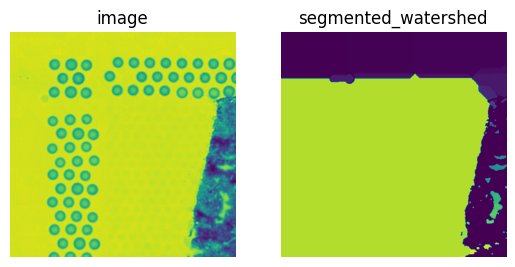

In [2]:
adata=ad.read_h5ad("../squidpy_input.h5ad")
library_id="None"
scale = adata.uns['spatial'][library_id]['scalefactors']['tissue_hires_scalef']
img = sq.im.ImageContainer(adata.uns['spatial'][library_id]['images']['hires'],
                           scale=scale, library_id=library_id)


# ADD IMG.SHOW TO PDF FILE
sq.im.process(img=img, layer="image", method="smooth")
sq.im.segment(img=img, layer="image_smooth", method="watershed", channel=0, chunks=1000)

# plot the resulting segmentation
fig, ax = plt.subplots(1, 2)
img_crop = img.crop_corner(0,0, size=500)
img_crop.show(layer="image", channel=0, ax=ax[0])
img_crop.show(
    layer="segmented_watershed",
    channel=0,
    ax=ax[1],
)

In [3]:
# define image layer to use for segmentation
features_kwargs = {"segmentation": {"label_layer": "segmented_watershed"}}
# calculate segmentation features
library_id = 'None'
sq.im.calculate_image_features(
    adata,
    img,
    features="segmentation",
    layer="image",
    key_added="features_segmentation",
    n_jobs=1,
    features_kwargs=features_kwargs,
)



/home/tcollins/anaconda3/envs/squidpy/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/3962 [00:00<?, ?/s]/home/tcollins/anaconda3/envs/squidpy/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tcollins/anaconda3/envs/squidpy/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/tcollins/anaconda3/envs/squidpy/lib/python3.8/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/tcollins/anaconda3/envs/squidpy/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: 

In [4]:
features = adata.obsm["features_segmentation"]
features = [i for i in features if "intensity_mean" in i]
features.append("segmentation_label")
features.append("clusters")
features

['segmentation_ch-0_mean_intensity_mean',
 'segmentation_ch-1_mean_intensity_mean',
 'segmentation_ch-2_mean_intensity_mean',
 'segmentation_label',
 'clusters']

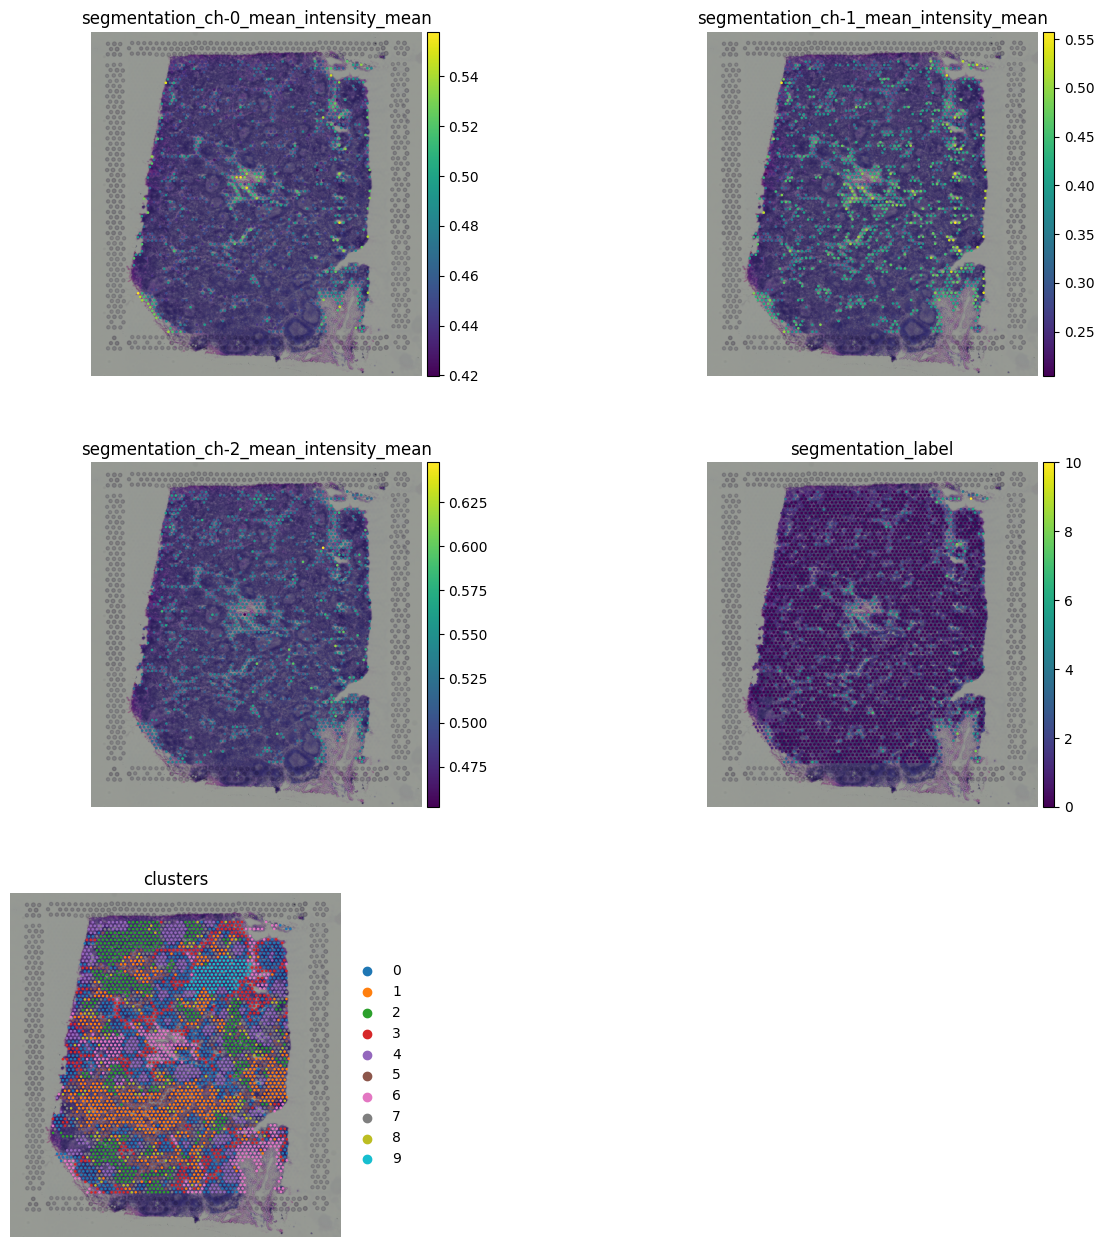

In [5]:
# plot results and compare with gene-space clustering
sq.pl.spatial_scatter(
    sq.pl.extract(adata, "features_segmentation"),
    color=features,
    frameon=False,
    ncols=2,
)

In [6]:
# define different feature calculation combinations
scale = adata.uns['spatial'][library_id]['scalefactors']['tissue_lowres_scalef']
params = {
    # all features, corresponding only to tissue underneath spot
    "features_orig": {
        "features": ["summary", "texture", "histogram"],
        "scale": 1.0,
        "mask_circle": True,
    },
    # summary and histogram features with a bit more context, original resolution
    "features_context": {"features": ["summary", "histogram"], "scale": 1.0},
    # summary and histogram features with more context and at lower resolution
    "features_lowres": {"features": ["summary", "histogram"], "scale" : 0.025},

    #Scale is not working therefore we will not use it in this itteration but we will allow a us
}

for feature_name, cur_params in params.items():
    # features will be saved in `adata.obsm[feature_name]`
    sq.im.calculate_image_features(adata, img, layer="image", key_added=feature_name, n_jobs=1, **cur_params)

# # combine features in one dataframe
adata.obsm["features"] = pd.concat([adata.obsm[f] for f in params.keys()], axis="columns")

# # make sure that we have no duplicated feature names in the combined table
adata.obsm["features"].columns = ad.utils.make_index_unique(adata.obsm["features"].columns)

  0%|          | 0/3962 [00:00<?, ?/s]

ValueError: applied function returned data with unexpected number of dimensions. Received 4 dimension(s) but expected 0 dimensions with names: ()

In [8]:
sq.__version__ 

'1.2.3'

In [ ]:
def cluster_features(features: pd.DataFrame, like=None):
    """
    Calculate leiden clustering of features.

    Specify filter of features using `like`.
    """
    # filter features
    if like is not None:
        features = features.filter(like=like)
    # create temporary adata to calculate the clustering
    adata = ad.AnnData(features)
    # important - feature values are not scaled, so need to scale them before PCA
    sc.pp.scale(adata)
    # calculate leiden clustering
    sc.pp.pca(adata, n_comps=min(10, features.shape[1] - 1))
    sc.pp.neighbors(adata)
    sc.tl.leiden(adata)

    return adata.obs["leiden"]

/home/tcollins/anaconda3/envs/squidpy/lib/python3.8/site-packages/anndata/utils.py:252: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


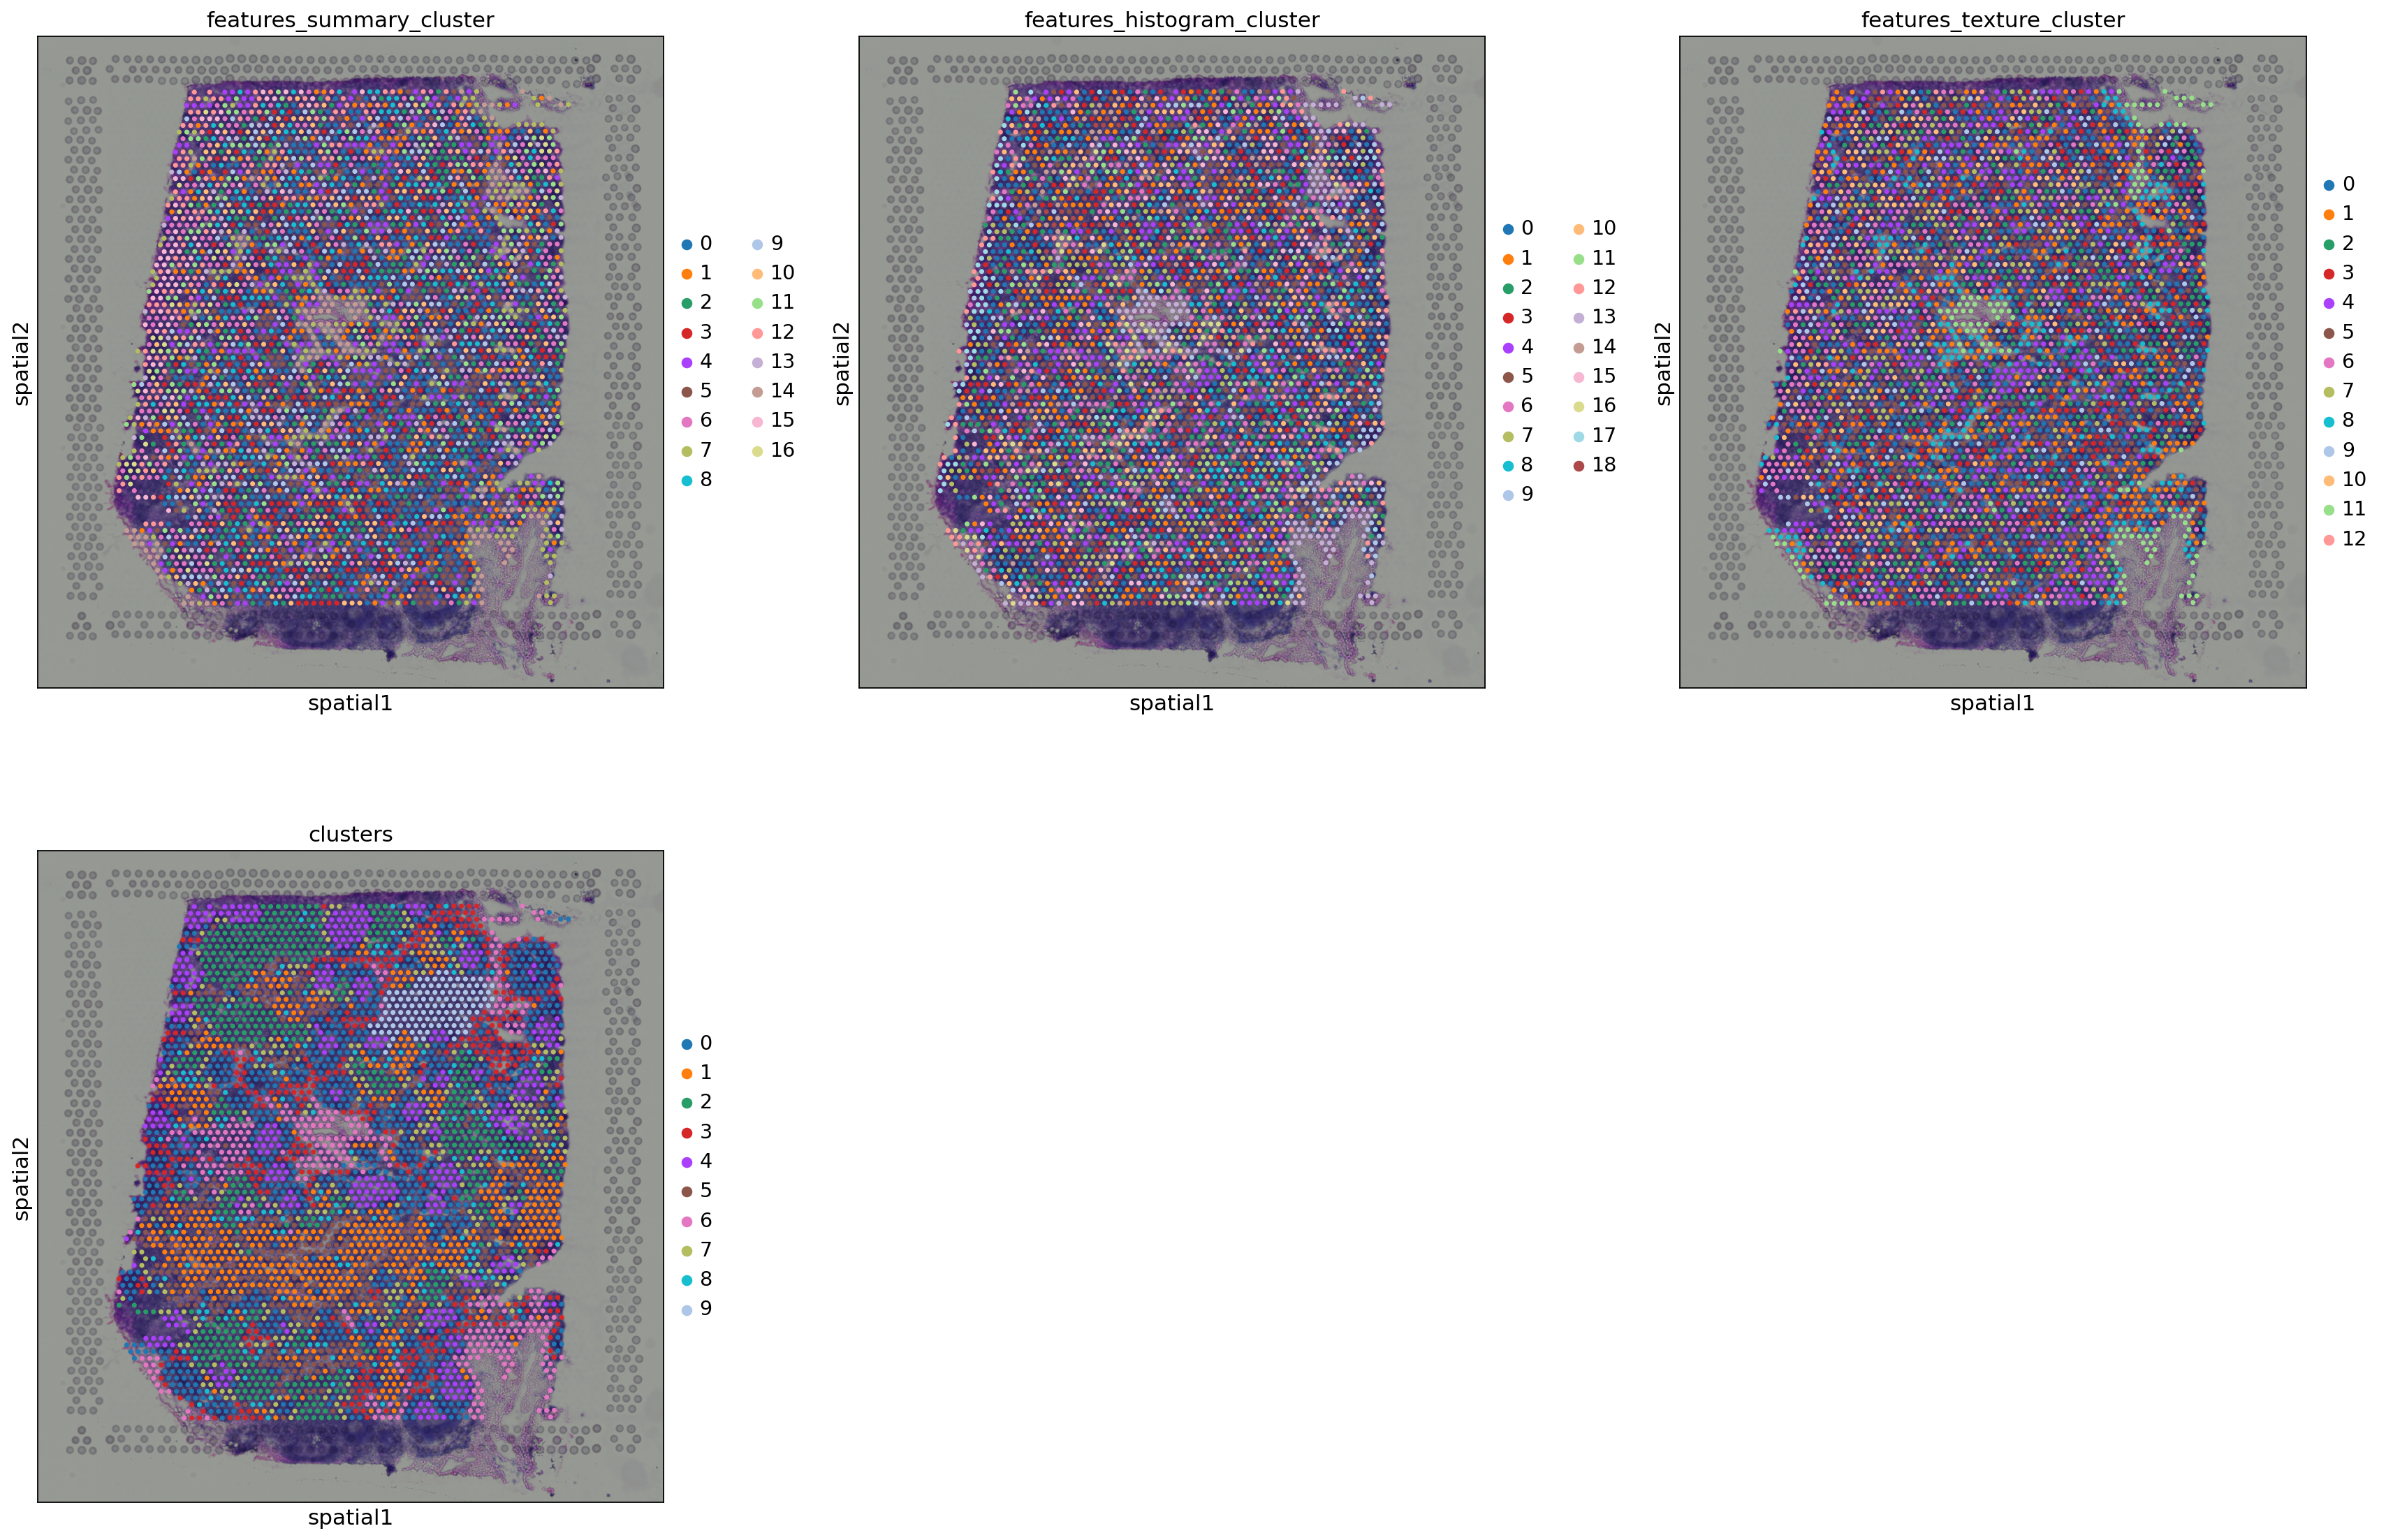

In [ ]:
adata.obs["features_summary_cluster"] = cluster_features(adata.obsm["features"], like="summary")
adata.obs["features_histogram_cluster"] = cluster_features(adata.obsm["features"], like="histogram")
adata.obs["features_texture_cluster"] = cluster_features(adata.obsm["features"], like="texture")

sc.set_figure_params(facecolor="white", figsize=(8, 8))
sq.pl.spatial_scatter(
    adata,
    color=[
        "features_summary_cluster",
        "features_histogram_cluster",
        "features_texture_cluster",
        "clusters",
    ],
    ncols=3,
)

100%|██████████| 1000/1000 [00:00<00:00, 3926.05/s]


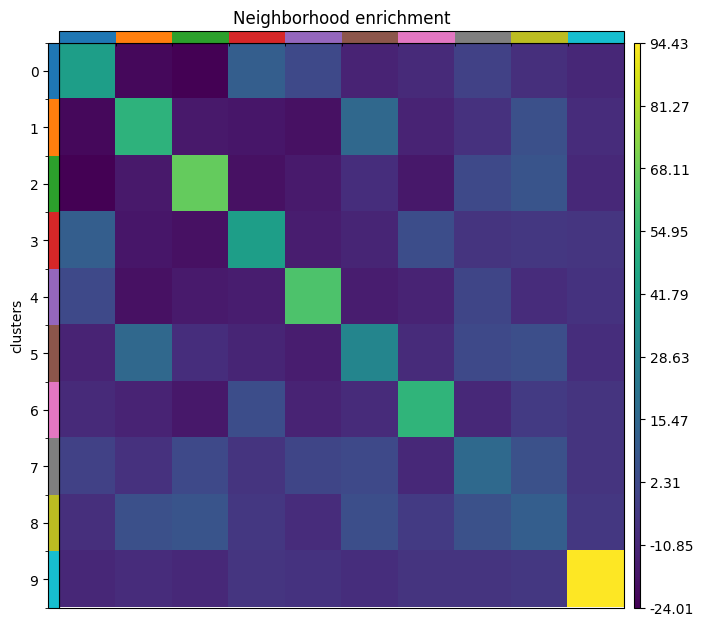

In [9]:
sq.gr.spatial_neighbors(adata)
sq.gr.nhood_enrichment(adata, cluster_key="clusters")
sq.pl.nhood_enrichment(adata, cluster_key="clusters")

In [43]:
clusters_list = adata.obs['clusters'].cat.categories

100%|██████████| 1/1 [00:01<00:00,  1.16s/]

ERROR: Unable to fetch palette, reason: 'clusters_colors'. Using `None`.



100%|██████████| 1/1 [00:01<00:00,  1.12s/]

ERROR: Unable to fetch palette, reason: 'clusters_colors'. Using `None`.



100%|██████████| 1/1 [00:01<00:00,  1.10s/]

ERROR: Unable to fetch palette, reason: 'clusters_colors'. Using `None`.



100%|██████████| 1/1 [00:01<00:00,  1.14s/]

ERROR: Unable to fetch palette, reason: 'clusters_colors'. Using `None`.



100%|██████████| 1/1 [00:01<00:00,  1.10s/]

ERROR: Unable to fetch palette, reason: 'clusters_colors'. Using `None`.



100%|██████████| 1/1 [00:01<00:00,  1.12s/]

ERROR: Unable to fetch palette, reason: 'clusters_colors'. Using `None`.



100%|██████████| 1/1 [00:01<00:00,  1.17s/]

ERROR: Unable to fetch palette, reason: 'clusters_colors'. Using `None`.



100%|██████████| 1/1 [00:01<00:00,  1.13s/]

ERROR: Unable to fetch palette, reason: 'clusters_colors'. Using `None`.



100%|██████████| 1/1 [00:01<00:00,  1.13s/]

ERROR: Unable to fetch palette, reason: 'clusters_colors'. Using `None`.



100%|██████████| 1/1 [00:01<00:00,  1.14s/]

ERROR: Unable to fetch palette, reason: 'clusters_colors'. Using `None`.


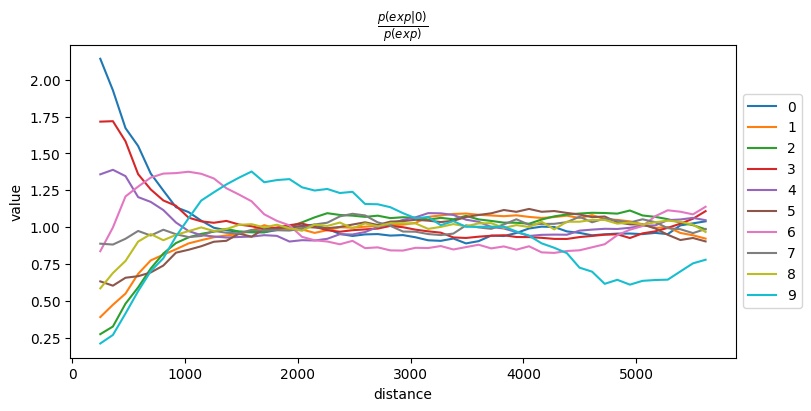

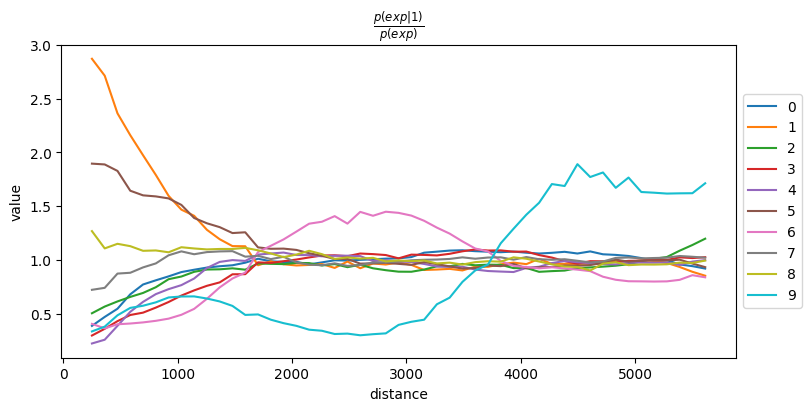

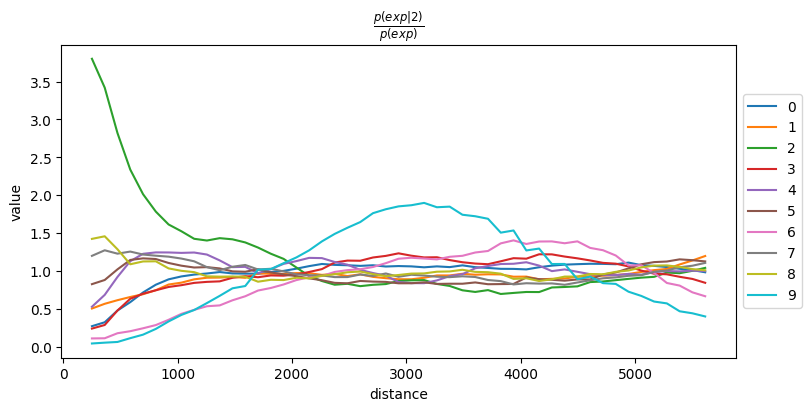

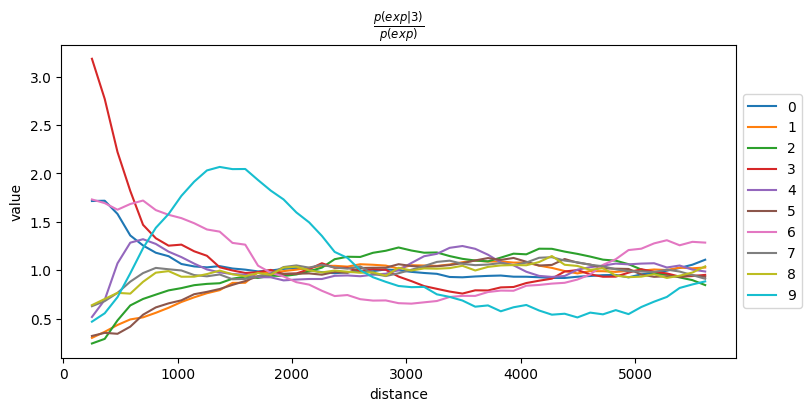

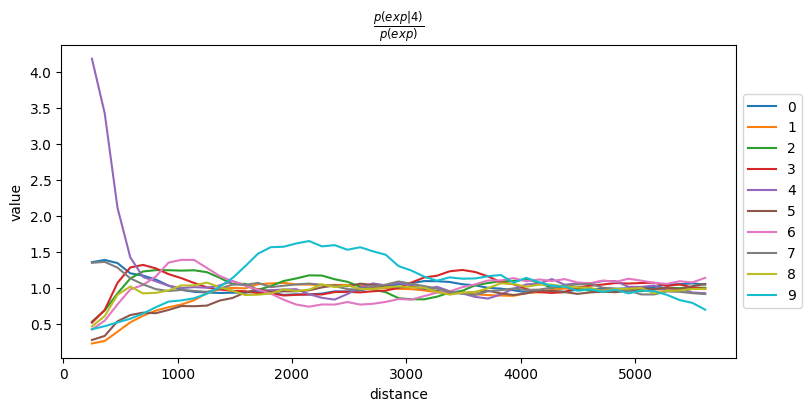

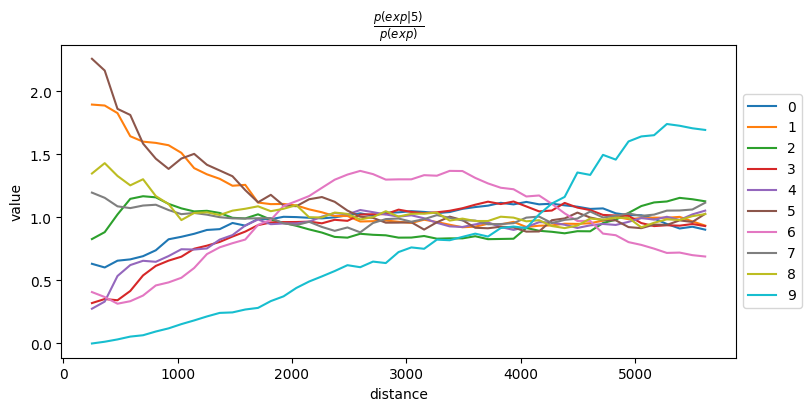

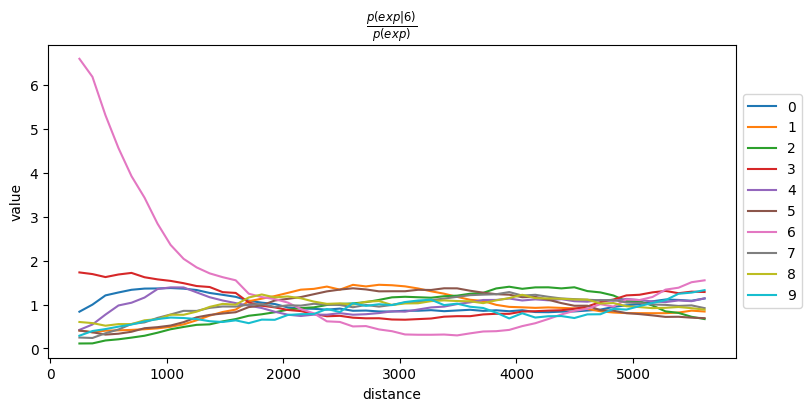

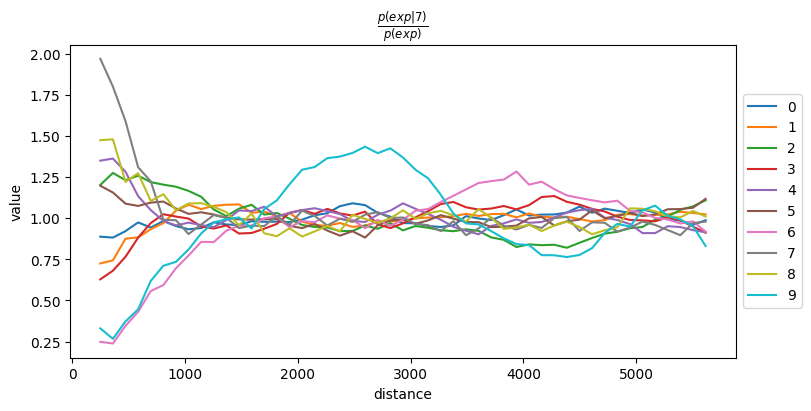

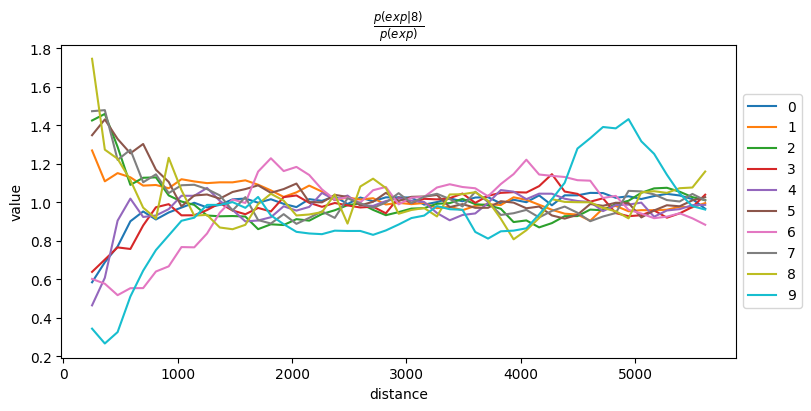

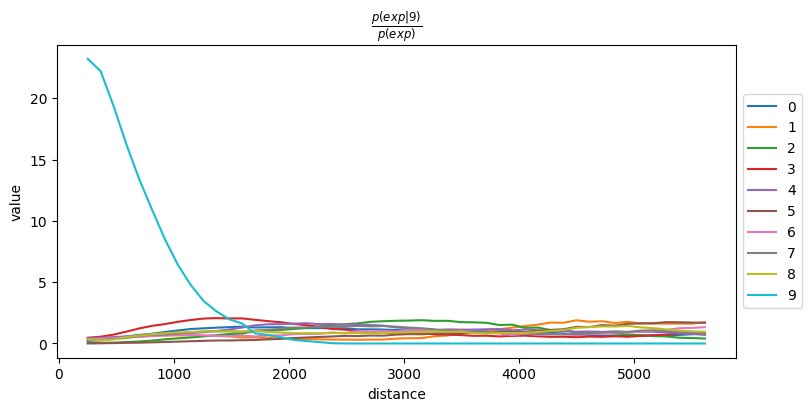

In [44]:
# Wrap this in a for loop and plot for every single cluster
for i in clusters_list:
    sq.gr.co_occurrence(adata, cluster_key="clusters")
    sq.pl.co_occurrence(
        adata,
        cluster_key="clusters",
        clusters=i,
        figsize=(8, 4),
    )